# Lab12 : Take Home Exercise

## st121411

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [223]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T+0.00001
    
    a = np.sum(W,axis=1)
#     for i,aa in enumerate(a):
#         #print(X[i])
#         print(aa)

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(n,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        #print(Mu)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label


### Example 3 Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [3]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [4]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [5]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [6]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
UnitPrice,0,0.00
InvoiceDate,0,0.00
Quantity,0,0.00
StockCode,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [7]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


In [8]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [9]:
Mu = np.std(data[numerical_colmns])
Sigma = np.mean(data[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64
Quantity     10.941200
UnitPrice     3.252928
TotalSum     22.146162
dtype: float64


In [10]:
# Check for outliers

def cnt_outlier(data,sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma**2
    return outlier.sum()

cnt_outlier(data,Sigma,Mu, numerical_colmns).sort_values(ascending=False)

Quantity     4650
UnitPrice      56
TotalSum       12
dtype: int64

In [11]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  987
      StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
4099        0.0       2.0          2.0       2.95      0.0       5.9
4131        0.0       2.0          2.0       2.95      0.0       5.9
4190        0.0       2.0          2.0       2.95      0.0       5.9
0           0.0       6.0          0.0       2.55      0.0      15.3
49          0.0       6.0          0.0       2.55      0.0      15.3


In [298]:
X = data.values

In [299]:
mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

In [300]:
print(X)

[[-1.3238868  -0.03572409 -1.0726451  -0.11163787 -0.26564736 -0.11949508]
 [-1.32140824 -0.03572409 -1.0726451   0.02039671 -0.26564736 -0.05026551]
 [-1.31892968 -0.02348829 -1.0726451  -0.08020106 -0.26564736 -0.0274637 ]
 ...
 [-0.60510319  0.66171654  1.5196613  -0.44643984  6.87883167  0.36263946]
 [-1.15038731  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]
 [-0.28784697  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]]


In [301]:
print(X.shape)

(4013, 6)


Here I removed extremely values where the standard deviation is greater than 5 as they bump into numerical errors and cause the program to crash.

In [302]:
far = np.sum(np.abs(X) > 5,axis=1)
far_index = np.where(far == 0)[0]
print(far_index)

[   0    1    2 ... 4003 4004 4005]


In [303]:
X = X[far_index,:]
print(X)
print(X.shape)

[[-1.3238868  -0.03572409 -1.0726451  -0.11163787 -0.26564736 -0.11949508]
 [-1.32140824 -0.03572409 -1.0726451   0.02039671 -0.26564736 -0.05026551]
 [-1.31892968 -0.02348829 -1.0726451  -0.08020106 -0.26564736 -0.0274637 ]
 ...
 [-0.67450298 -0.06631359  1.5196613  -0.04876426 -0.26564736 -0.28913501]
 [-0.97440925 -0.03572409  1.5196613   0.26560379 -0.26564736  0.0783037 ]
 [ 1.08775616 -0.29267589  1.5196613  -0.18237068 -0.26564736 -1.36809992]]
(3920, 6)


In [317]:
K = 8

likelihoods = []
threshold = np.matrix(.01)

for k in range(2,K+1):
    print(k,end= "\t")
    likelihood = -float('inf')
    
    for attempt in range(10):
        Phi, Mu, Sigma = init_gmm(X, k)

        converged = False
        while not converged:
            converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

        l = np.mean(np.log(pj))
        if(l > likelihood):
            likelihood = l
        
    print(likelihood)
    likelihoods.append(likelihood)

2	2.6161389468572533
3	4.000412839849241
4	5.194349101349391
5	5.368373840802291
6	6.305881634595087
7	6.344063576868965
8	6.9813860076362255


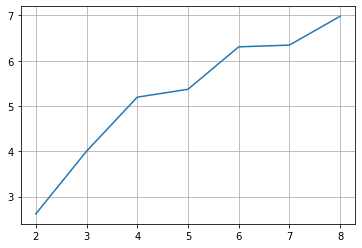

In [318]:
plt.plot(range(2,K+1),likelihoods)
plt.grid(True)

The graph seems to have two elbows at k = 4 and k = 6. We will select k = 4.

In [319]:
k = 4
threshold = np.matrix(.01)

print(k,end= "\t")
likelihood = -float('inf')

for attempt in range(5):
    Phi, Mu, Sigma = init_gmm(X, k)

    converged = False
    while not converged:
        converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

    l = np.mean(np.log(pj))
    if(l > likelihood):
        likelihood = l
        best_Phi = Phi
        best_Mu = Mu
        best_Sigma = Sigma

4	

In [363]:
m_distance = np.zeros((X.shape[0],best_Mu.shape[1]))

for kk in range(best_Mu.shape[1]):
    for i, x in enumerate(X):
        mu = best_Mu[:,kk]
        sig = best_Sigma[kk]
        sig_inv = np.linalg.inv(sig)
        diff = (mu-x).reshape(-1,1)
        distance = np.sqrt(diff.T@sig_inv@diff)
        m_distance[i,kk] = distance

a = np.argmin(m_distance,axis=1)
(unique, counts) = np.unique(a, return_counts=True)

max_z_score = 5
min_distance = np.min(m_distance,axis=1)
outlier = min_distance > max_z_score
outlier = np.nonzero(outlier)[0]
print(outlier)

[ 114  181  322  607 1020 1402 2199 2549 2555 2953 3091 3101 3107 3756]


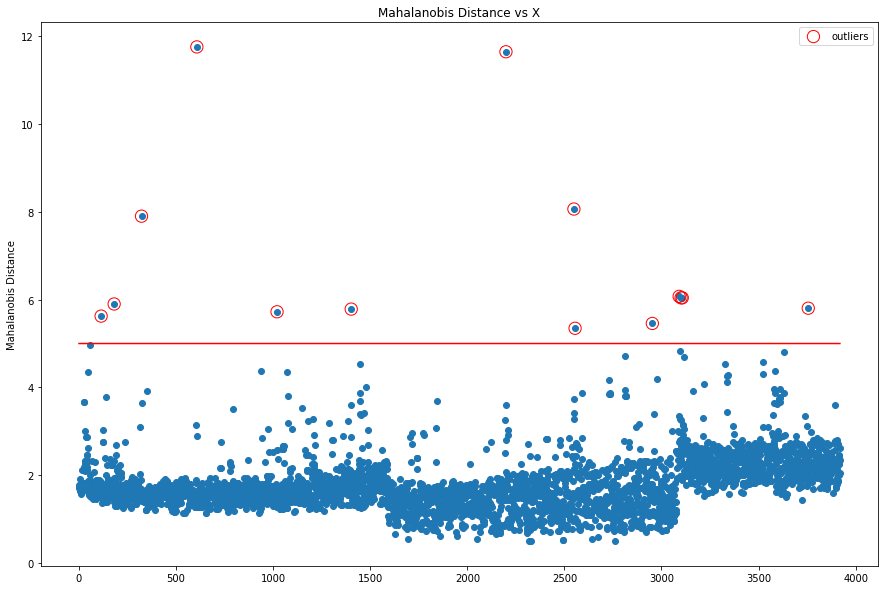

In [364]:
fig = plt.figure(figsize=(15,10))

plt.title("Mahalanobis Distance vs X")
plt.plot(range(X.shape[0]),np.full(X.shape[0],max_z_score),c='r')
plt.ylabel("Mahalanobis Distance")

plt.scatter(range(X.shape[0]),min_distance)
plt.scatter(outlier,min_distance[outlier],s=150,facecolor='none',edgecolor = 'r',label="outliers")
plt.legend()

In [365]:
pj[outlier]

array([6.42344043e-007, 1.03030148e-038, 5.11698924e-011, 1.32399910e-152,
       2.03340255e-006, 1.52377207e-004, 7.53355374e-146, 8.28582039e-010,
       1.35483081e-031, 5.23392882e-034, 1.03100860e-030, 1.52750589e-009,
       1.52402446e-009, 1.61894943e-004])